This notebook is the second part of an introduction to machine learning and implements an Multilayer perceptron (MLP) for a binary classification task.

In [4]:
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.datasets import make_circles

Dimension de X: (100, 2)
Dimension de Y: (100, 1)


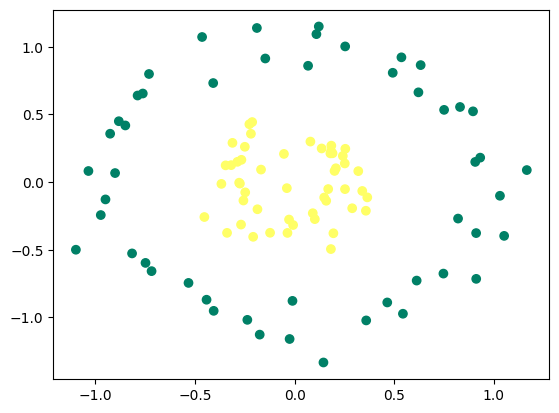

In [6]:
X,Y = make_circles(n_samples=100, noise=0.1, factor=0.3, random_state=0)
Y = Y.reshape((Y.shape[0], 1))

print(f"Dimension de X: {X.shape}")
print(f"Dimension de Y: {Y.shape}")

plt.scatter(X[:,0], X[:,1], c=Y, cmap='summer')
plt.show()